# Daily Climate time series data

# Importing Libraries and Loading Data

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/DailyDelhiClimateTrain.csv
/kaggle/input/DailyDelhiClimateTest.csv


# 

In [13]:
#     Importing all the necessary Libraries

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import datetime as dt

# Loading Models, Grid Search, and metric for evaluation

In [14]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet,Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import xgboost as xgb

# Loading Data

In [15]:
import io
train = pd.read_csv('/kaggle/input/DailyDelhiClimateTrain.csv')

# Data Description

In [16]:
train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


# **Data is presented by 5 attributes for total of 1462 days.**

* date - Date
* meantemp - Mean temperature averaged out from multiple 3 hour intervals in a day.
* humidity - Humidity value for the day (units are grams of water vapor per cubic meter volume of air).
* wind_speed - Wind speed measured in kmph.
* Pressure reading of weather (measure in atm).

In [17]:
train.describe().style.background_gradient(cmap = 'Oranges')

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


There are outliers both in terms of minimum and maximum values in all features.
There is a question with atmospheric pressure. In what units is it represented and how is it measured?

Let's look at the data type.

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


# Exploratory Data Analysis and statistical tests

Let's check our dataset for information gaps

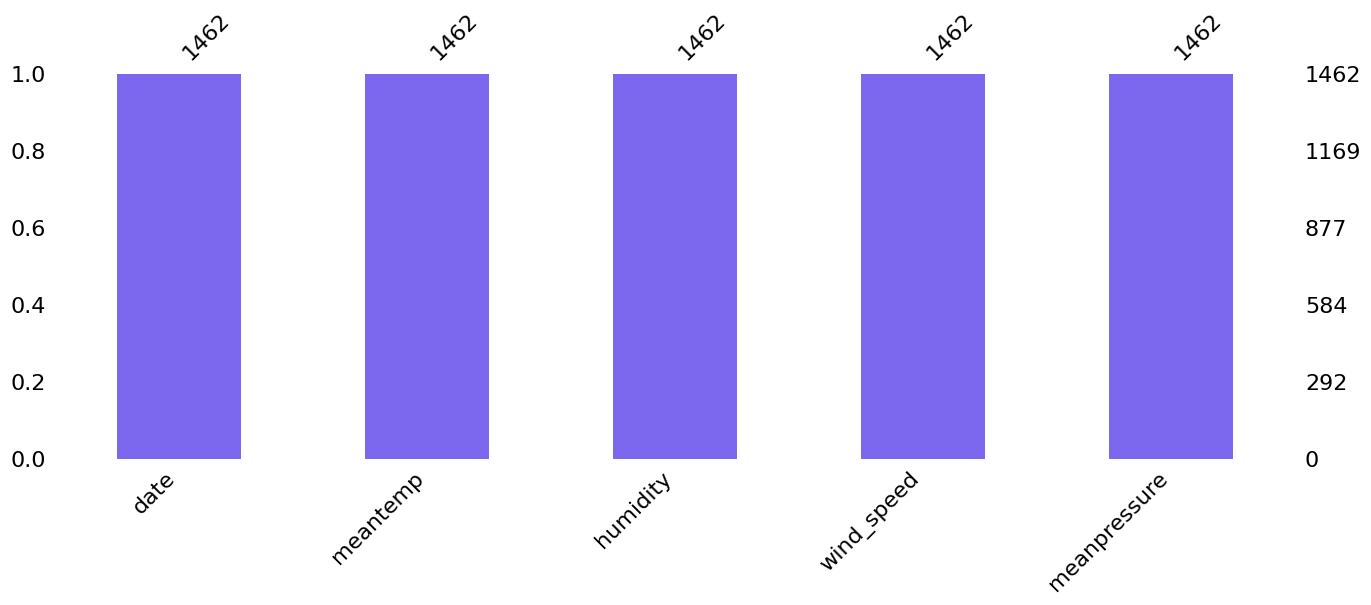

In [19]:
msno.bar(train, figsize = (16,5),color = "#7B68EE")
plt.show()

There are no gaps in the data.

Visualize the change in temperature depending on the date

# Temperature vs Date

In [20]:
fig = px.line(train, x='date', y='meantemp', title="Temperature change",template='plotly_dark')

fig.show()

The graph shows the **seasonality** of temperature changes. This will help predict the temperature value for the whole year 

# Humadity vs Date

In [21]:
fig = px.line(train, x='date', y='humidity', title="Humidity change",template='plotly_dark')

fig.show()

There is also **seasonality**.

# Wind Speed vs Date

In [22]:
fig = px.line(train, x='date', y='wind_speed', title="Change in wind speed",template='plotly_dark')

fig.show()

A slight correlation

# Mean Pressure vs Date

In [23]:
fig = px.line(train, x='date', y='meanpressure', title="Pressure Changes",template='plotly_dark')

fig.show()

**Hypothesis: this feature has no correlation with the rest.**

# Decomposition of temperature value into seasonality, trend and residual components.

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
ts_decomposition = seasonal_decompose(x=train['meantemp'], model='additive', period=13)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

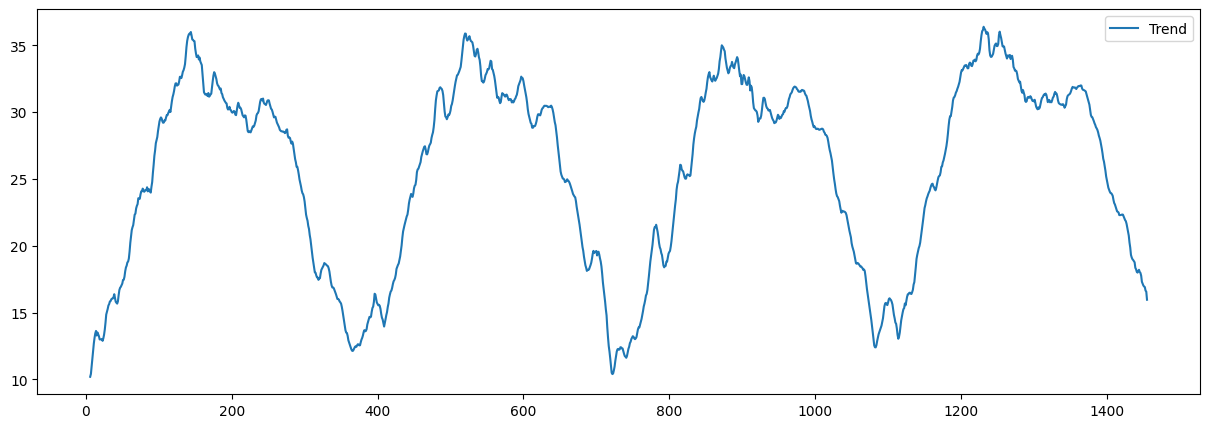

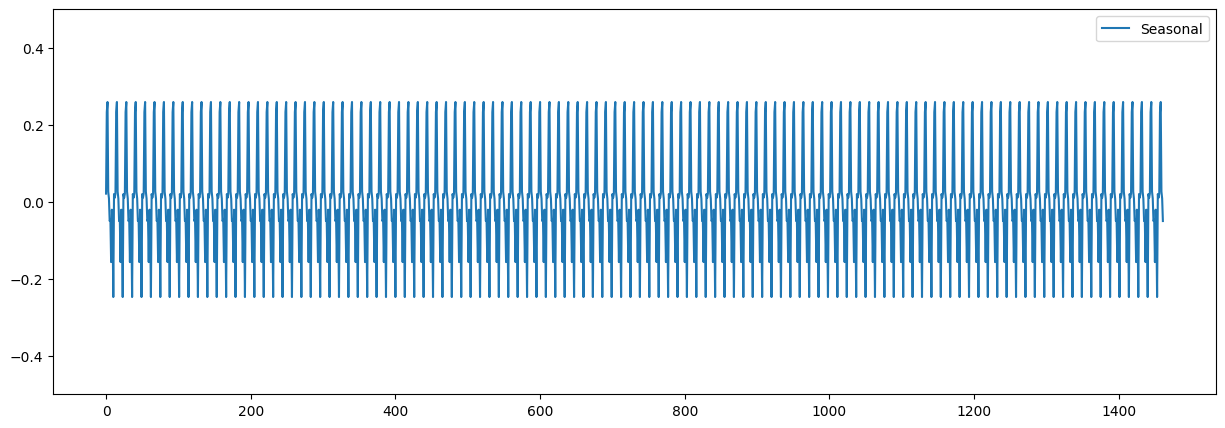

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.ylim(-0.5, 0.5)
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

There are large residuals in the data.

# Adding Useful Columns

In [27]:
train['date'] = pd.to_datetime(train['date'], format = '%Y-%m-%d')

In [28]:
train['Day_of_Week'] = train['date'].dt.dayofweek
train['YEAR']=train['date'].dt.year
train['DAY']=train['date'].dt.day
train['MONTH']=train['date'].dt.month

In [29]:
train.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure',
       'Day_of_Week', 'YEAR', 'DAY', 'MONTH'],
      dtype='object')

Let's analyze our features.

In [30]:
numeric_features=['meantemp', 'humidity', 'wind_speed', 'meanpressure']

In [31]:
fig = make_subplots(rows=len(numeric_features), cols=3)
i=1
for feature in numeric_features:
  fig.add_trace(go.Histogram(x=train[feature], name=feature), row=i, col=1)
  fig.add_trace(go.Box(x=train[feature], name=feature), row=i, col=2)
  fig.add_trace(go.Violin(x=train[feature], name=feature), row=i, col=3)
  i+=1
fig.update_layout(height=2400, width=1800, title_text='<b>Continuos distributions', title_x=0.5)
fig.show()

* There are minor outliers for all two features. One feature is outliers both in terms of the maximum and minimum values.
* Features are not normally distributed, with the exception of humidity and possibly atmospheric pressure.

Our interest is in the target sign - "the average temperature". 


# Histogram of the distribution of unit differences for temperature

In [32]:
tempdiff=train['meantemp'].diff(periods=1).dropna()

In [33]:
fig = go.Figure(data=[go.Histogram(x=tempdiff,histnorm='probability density')])
fig.update_layout(
    title="Histogram of unit differences of mean temperature",
    title_x = 0.5,
    xaxis_title="Unit difference",
    yaxis_title="Probability Density",
    legend=dict(x=.5, xanchor="center", orientation="h"),
    margin=dict(l=0, r=0, t=30, b=0))
fig.show()

Hypothesis: a series of unit differences is stationary and further work with it is possible.

Building scatterplots of our feature with other features in the table.

# Scatterplots

In [34]:
for feature in numeric_features:
  fig = px.scatter(train, x='meantemp',y=feature)
  fig.update_layout(title=f"meantemp with {feature}")
  fig.show()

There is a slight inverse correlation with the sign of humidity.

Now, checking the unit difference in temperature with the value of humidity.

In [35]:
fig = px.scatter(x=tempdiff,y=train.humidity[1:])
fig.update_layout(title="tempdiff with humidity")
fig.show()

The graph below shows that it is not possible to predict the temperature value from the previous day's humidity value.

Let's look at sliding windows using exponential smoothing.

# Sliding Window Using Exponential Smoothing

In [36]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

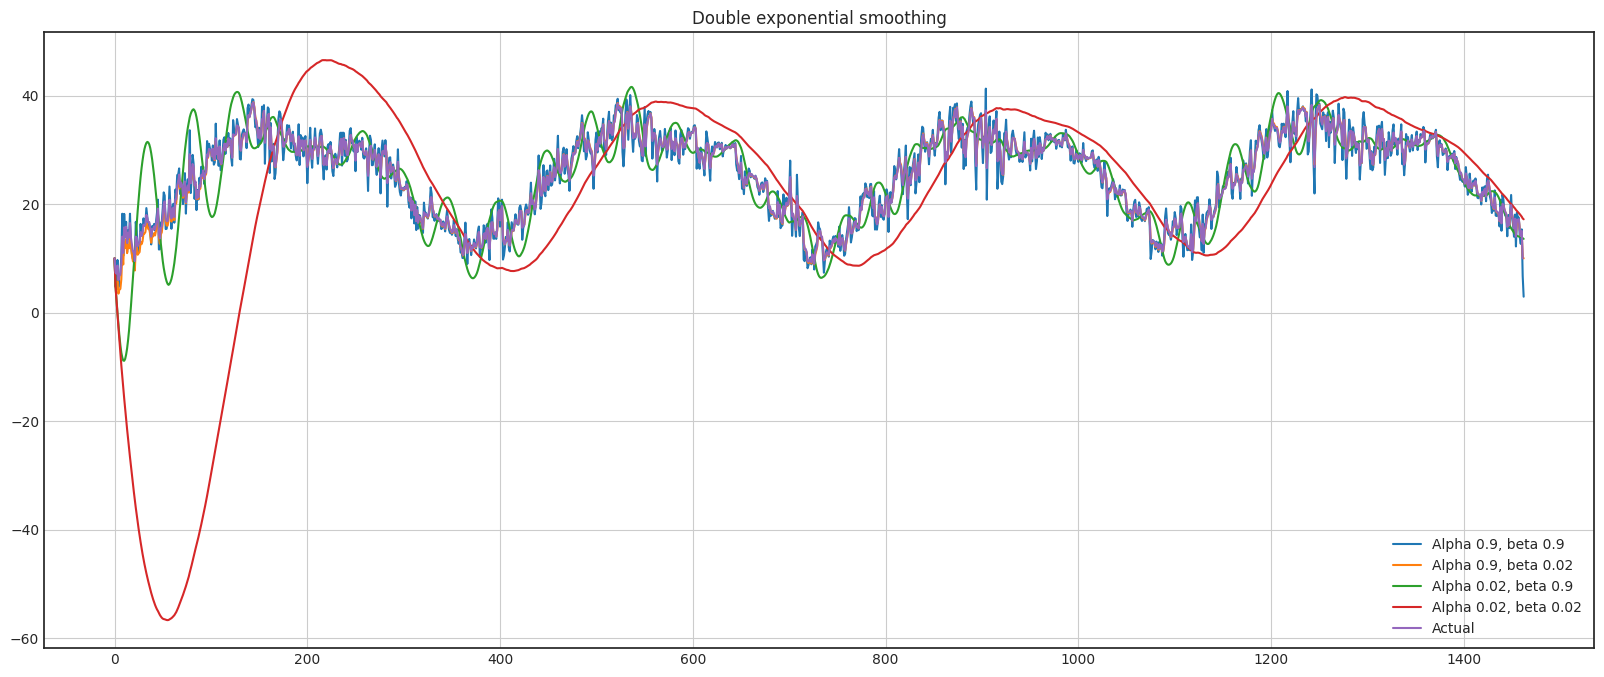

In [37]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(train.meantemp, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(train.meantemp.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double exponential smoothing")
    plt.grid(True)

Let's analyze by dates.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/

<Axes: xlabel='MONTH', ylabel='meantemp'>

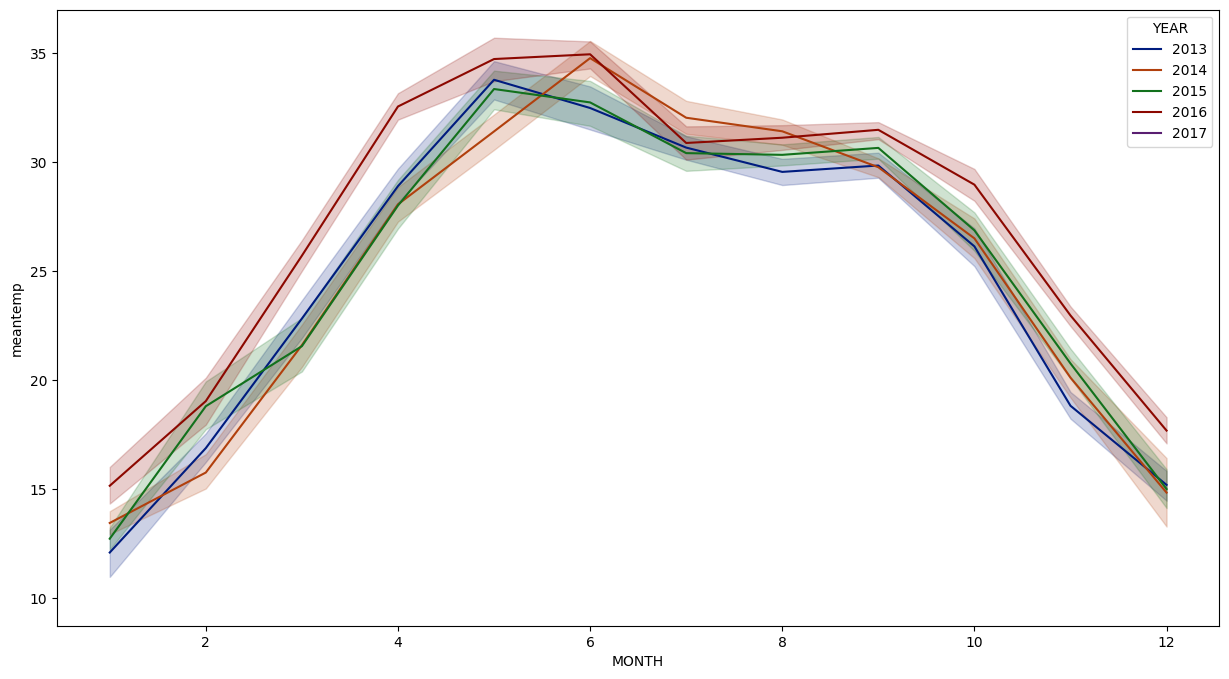

In [38]:
plt.figure(figsize=(15,8))
sns.lineplot(data=train,x='MONTH',y='meantemp',hue='YEAR',palette='dark')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/

<Axes: xlabel='YEAR', ylabel='meantemp'>

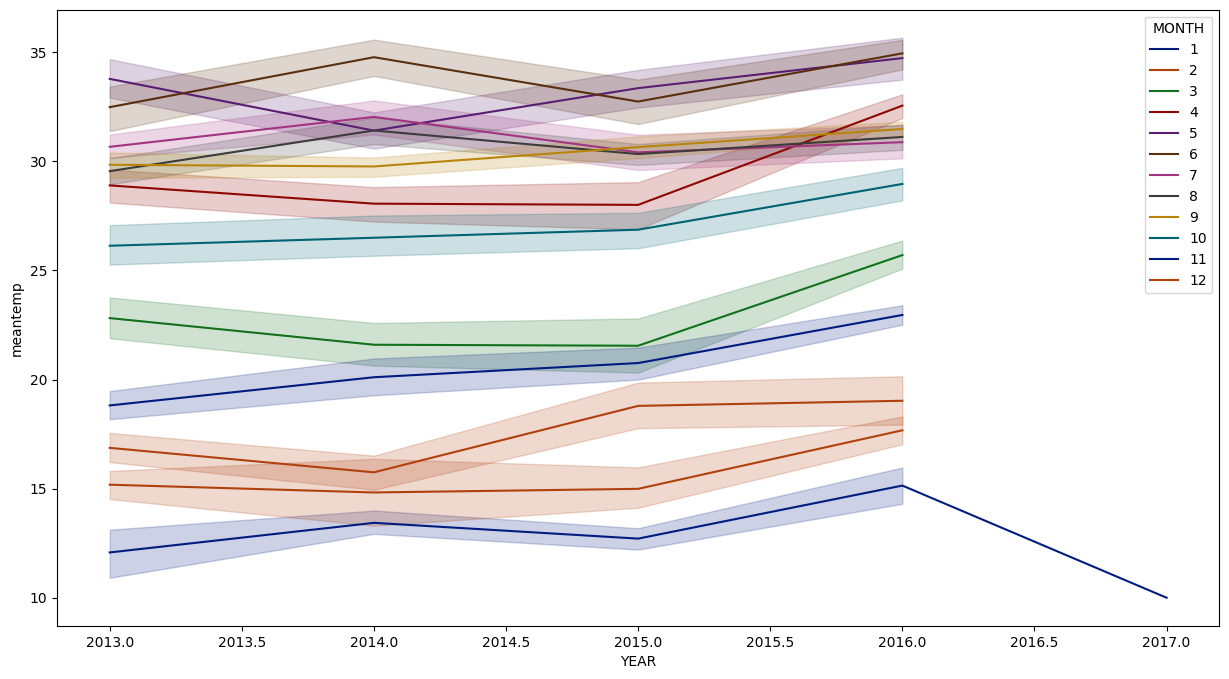

In [39]:
plt.figure(figsize=(15,8))
sns.lineplot(data=train,x='YEAR',y='meantemp',hue='MONTH',palette='dark')

As we can see, the average temperature increases from year to year. This is primarily due to global climate change.

Let's run statistical tests with our dataset. it is proposed to start with the construction of a correlation matrix.

In [40]:
correlation = train.corr()
print(correlation['meantemp'].sort_values(ascending = False),'\n')

meantemp        1.000000
wind_speed      0.306468
date            0.130454
MONTH           0.122667
YEAR            0.103803
DAY             0.006475
Day_of_Week    -0.009941
meanpressure   -0.038818
humidity       -0.571951
Name: meantemp, dtype: float64 



# Columns for Correlation 

In [41]:

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
correlation = train[numeric_cols].corr()
print(correlation['meantemp'].sort_values(ascending=False), '\n')


meantemp        1.000000
wind_speed      0.306468
MONTH           0.122667
YEAR            0.103803
DAY             0.006475
Day_of_Week    -0.009941
meanpressure   -0.038818
humidity       -0.571951
Name: meantemp, dtype: float64 



# Correlation Martix

Selected columns for the heatmap: ['meantemp', 'humidity', 'wind_speed', 'MONTH', 'YEAR', 'meanpressure', 'Day_of_Week', 'DAY']


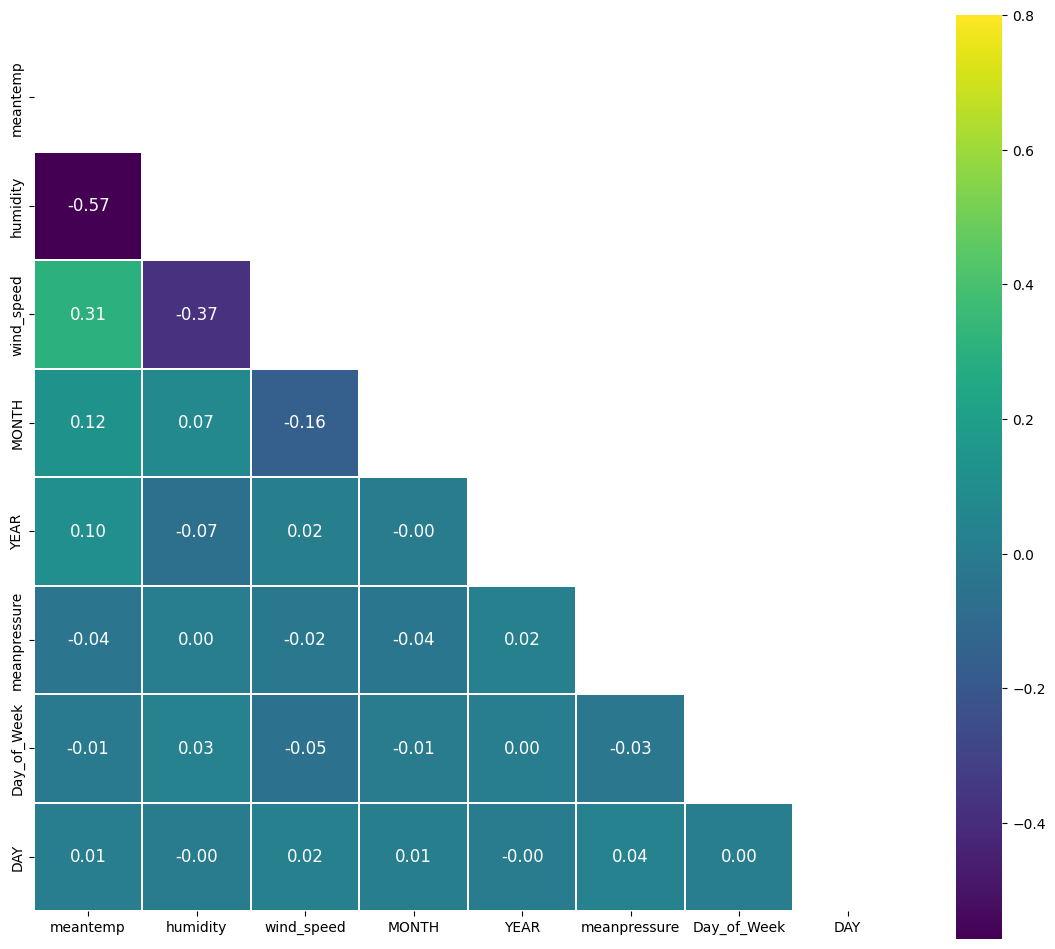

In [42]:


k = 10


numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
correlation = train[numeric_cols].corr()

top_features = correlation['meantemp'].drop('meantemp').abs().sort_values(ascending=False).head(k-1).index.tolist()
cols = ['meantemp'] + top_features


print("Selected columns for the heatmap:", cols)


cm = np.corrcoef(train[cols].values.T)
mask = np.triu(np.ones_like(cm, dtype=bool))
f, ax = plt.subplots(figsize=(14, 12))


sns.heatmap(cm, mask=mask, annot=True, fmt=".2f", cmap='viridis', linewidths=0.01,
            square=True, vmax=.8, linecolor='white', xticklabels=cols, yticklabels=cols, annot_kws={'size': 12})

plt.show()


* There is a slight inverse correlation with humidity.

Let's check if there is statistical significance between year, month, day and average temperature.

In [43]:
train.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure',
       'Day_of_Week', 'YEAR', 'DAY', 'MONTH'],
      dtype='object')

# Mannwhitneyu Tests

In [44]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(train['Day_of_Week'], train['meantemp'])
print('Mann-Whitney test=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
		print('You cant reject the null hypothesis')
else:
		print('Rejecting the null hypothesis')

Mann-Whitney test=104.500, p=0.000
Rejecting the null hypothesis


In [45]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(train['YEAR'], train['meantemp'])
print('Mann-Whitney test=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
		print('You cant reject the null hypothesis')
else:
		print('Rejecting the null hypothesis')

Mann-Whitney test=2137444.000, p=0.000
Rejecting the null hypothesis


In [46]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(train['DAY'], train['meantemp'])
print('Mann-Whitney test=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
		print('You cant reject the null hypothesis')
else:
		print('Rejecting the null hypothesis')

Mann-Whitney test=431684.000, p=0.000
Rejecting the null hypothesis


In [47]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(train['MONTH'], train['meantemp'])
print('Mann-Whitney test=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
		print('You cant reject the null hypothesis')
else:
		print('Rejecting the null hypothesis')

Mann-Whitney test=13072.000, p=0.000
Rejecting the null hypothesis


There is statistical significance in the data.

Let's check our target feature for stationarity.

# Stationarity Check

Dickey-Fuller criterion: p=0.277412


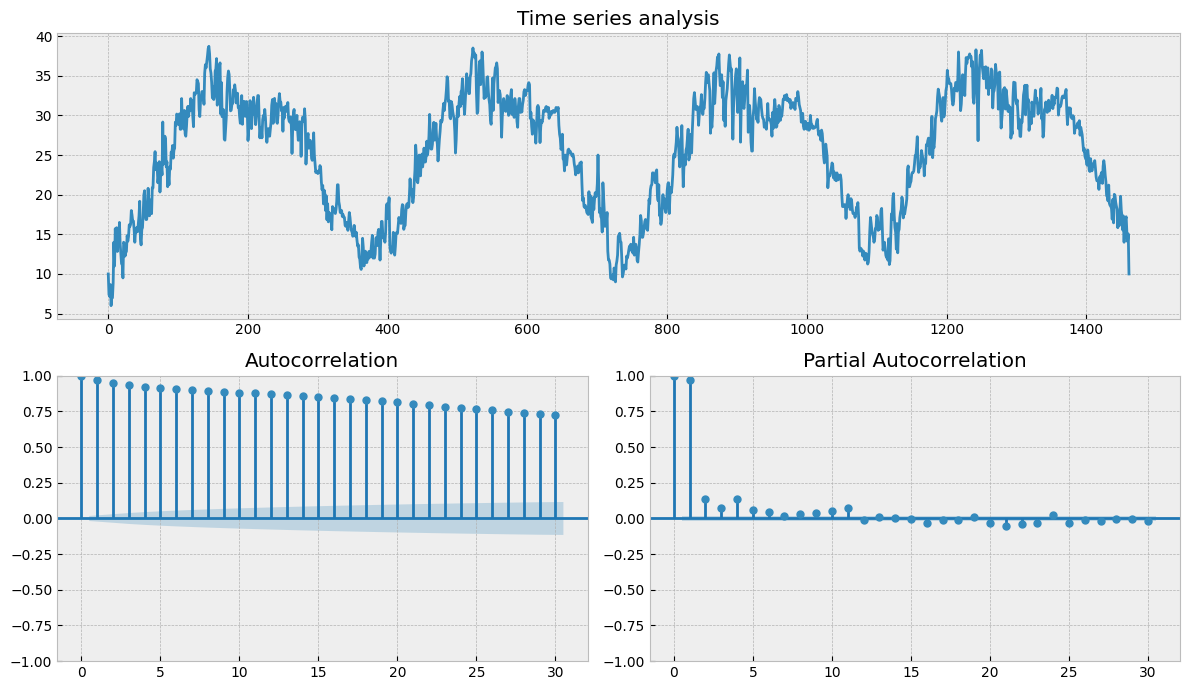

In [48]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time series analysis')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(train.meantemp, lags=30)

The series is non-stationary.

Let us check a number of unit differences for stationarity.

Dickey-Fuller criterion: p=0.000000


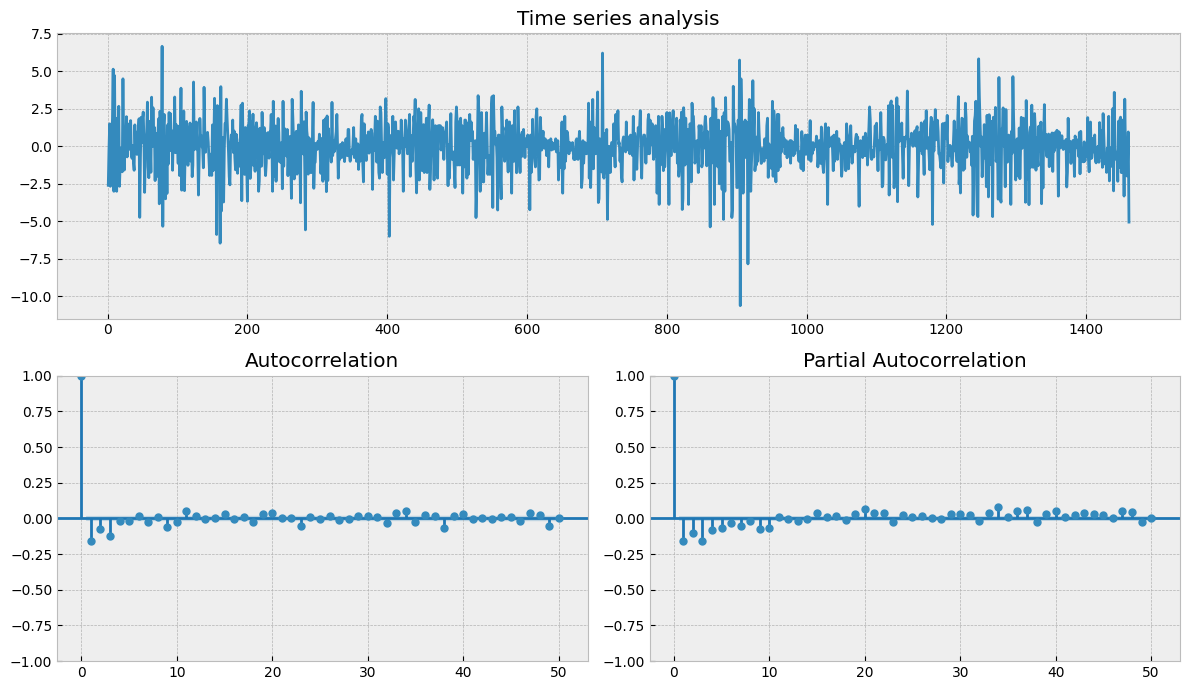

In [49]:
tsplot(tempdiff, lags=50)

The Dickey-Fuller test is equal to zero, but it has a high variance in the form of the graph.

# Forecasting

Let's forecast the initial series using the ARIMA model for a period of 30 days. 

In [50]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:0000:0100:01


In [51]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from statsmodels.tsa.stattools import adfuller


# Load Data

In [151]:
train = pd.read_csv('../input/DailyDelhiClimateTrain.csv')
test = pd.read_csv('../input/DailyDelhiClimateTest.csv')
#print("Train")
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [152]:
print("Test")
test.head()

Test


,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [153]:


train.drop(labels = 'meanpressure', axis = 1,inplace = True)
test.drop(labels = 'meanpressure', axis = 1,inplace = True)

result = adfuller(train['meantemp'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -2.021069055920673
p-value: 0.2774121372301602


In [154]:
#print("Train")
train.head()

,date,meantemp,humidity,wind_speed
0,2013-01-01,10.000000,84.500000,0.000000
1,2013-01-02,7.400000,92.000000,2.980000
2,2013-01-03,7.166667,87.000000,4.633333
3,2013-01-04,8.666667,71.333333,1.233333
4,2013-01-05,6.000000,86.833333,3.700000


In [155]:
#print("Test")
test.head()

,date,meantemp,humidity,wind_speed
0,2017-01-01,15.913043,85.869565,2.743478
1,2017-01-02,18.500000,77.222222,2.894444
2,2017-01-03,17.111111,81.888889,4.016667
3,2017-01-04,18.700000,70.050000,4.545000
4,2017-01-05,18.388889,74.944444,3.300000


In [94]:
train_ = train.copy()
test_ = test.copy()


# Plots of Train and Test Data

In [95]:
train_['date'] = pd.to_datetime(train_['date'])




train_['formatted_date'] = train_['date'].dt.strftime('%d-%m-%Y')


fig = go.Figure()

fig.add_trace(go.Scatter(x=train_['formatted_date'], y=train_['meantemp'], 
                         mode='lines+markers', name='Train', 
                         marker=dict(symbol='triangle-down')))


fig.update_layout(
    title='Mean Temperature vs Date',
    xaxis_title='Date (DD-MM-YYYY)',
    yaxis_title='Mean Temperature',
    xaxis=dict(tickangle=45, showticklabels=True),
    autosize=True,
    width=1200,
    height=600,
    margin=dict(l=40, r=40, b=40, t=40),
    hovermode='closest'
)


fig.update_xaxes(rangeslider_visible=True)


fig.show()


In [96]:


test_['date'] = pd.to_datetime(test_['date'])

test_['date'] = pd.to_datetime(test_['date'])

test_['formatted_date'] = test_['date'].dt.strftime('%d-%m-%Y')


fig = go.Figure()

fig.add_trace(go.Scatter(x=test_['formatted_date'], y=test_['meantemp'], 
                         mode='lines+markers', name='Test', 
                         marker=dict(symbol='triangle-down')))


fig.update_layout(
    title='Mean Temperature vs Date',
    xaxis_title='Date (DD-MM-YYYY)',
    yaxis_title='Mean Temperature',
    xaxis=dict(tickangle=45, showticklabels=True),
    autosize=True,
    width=1200,
    height=600,
    margin=dict(l=40, r=40, b=40, t=40),
    hovermode='closest'
)


fig.update_xaxes(rangeslider_visible=True)


fig.show()


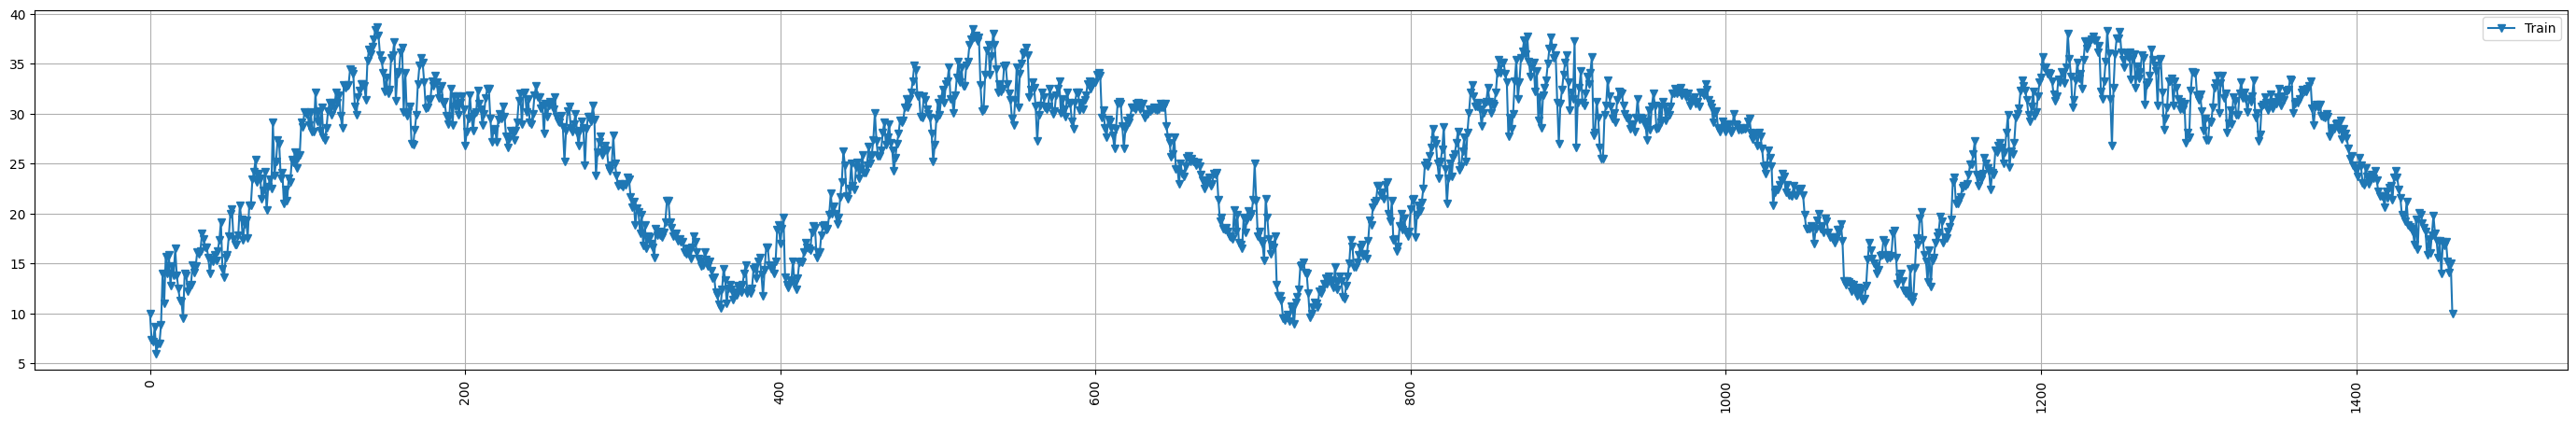

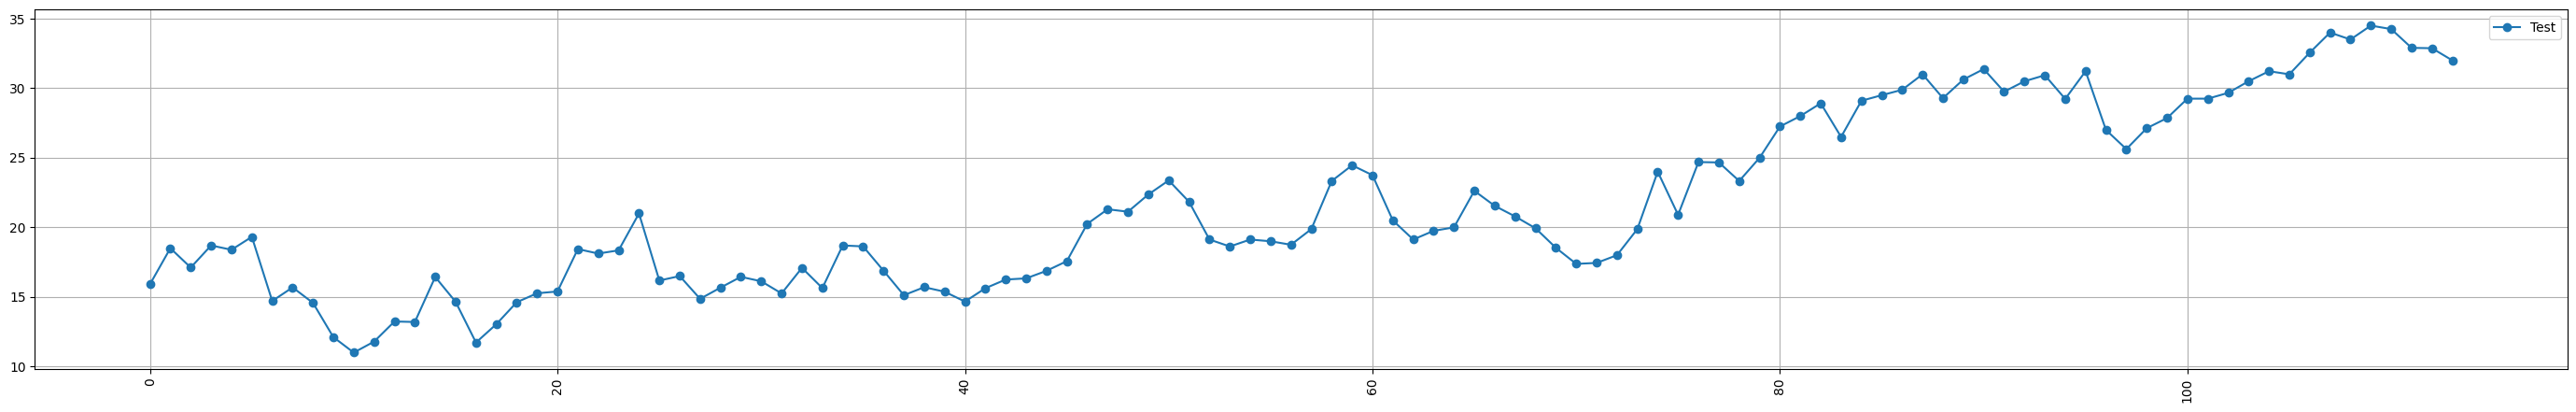

In [97]:

plt.figure(figsize=(35,5))
plt.grid()
plt.plot(train_['meantemp'], marker='v', label='Train')

plt.xticks(rotation=90)
plt.legend()
plt.show()


plt.figure(figsize=(35,5))
plt.grid()

plt.plot( test_['meantemp'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Benchmarks for Error Calculations

> Symmetrical Mean Absolute Percentage Error (sMAPE)

$$e_{sM} = \frac{200\%}{k} \sum_{t=1}^{k} \frac{|y_t - \hat{y}_t|}{|y_t + \hat{y}_t|}$$

> Mean Absolute Scaled Error (MASE)

$$e_{MA} = \frac{1}{k} \sum_{t=1}^{k} \frac{|y_t - \hat{y}_t|}{\frac{1}{n-m} \sum_{i=m+1}^{n} |y_i - y_{i-m}|}$$

> Mean Wrong-Estimation Shares ($\rho_U$ and $\rho_O$)

$$
\rho_U = \frac{1}{k} \sum_{t=1}^{k} \max(\text{sgn}(y_t - \hat{y}_t), 0)
$$

$$
\rho_O = \frac{1}{k} \sum_{t=1}^{k} \max(\text{sgn}(\hat{y}_t - y_t), 0)
$$

> Mean Wrong-Accuracy Shares ($\delta_U$ and $\delta_O$)

$$
\delta_U = \begin{cases} 
\frac{1}{k \cdot \rho_U} \sum_{t=1}^{k} \frac{\max(y_t - \hat{y}_t, 0)}{|y_t|}, & \text{if } \rho_U > 0 \\
0, & \text{otherwise}
\end{cases}
$$

$$
\delta_O = \begin{cases} 
\frac{1}{k \cdot \rho_O} \sum_{t=1}^{k} \frac{\max(\hat{y}_t - y_t, 0)}{|y_t|}, & \text{if } \rho_O > 0 \\
0, & \text{otherwise}
\end{cases}
$$

> The Mean Squared Error (MSE) 
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

> Coefficient of Determination (R²)

$$
\text{R^2} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$


In [132]:
def smape(y_pred, y_actual):
    """
    Symmetrical Mean Absolute Percentage Error (sMAPE)
    """
    ans = (200.0 / len(y_pred)) * np.sum(np.abs(y_actual - y_pred) / (np.abs(y_actual + y_pred)))
    print(f"sMAPE: {ans:.2f}%")
    return ans

def mase(y_pred, y_actual, seasonality=1):
    """
    Mean Absolute Scaled Error (MASE)
    """
    n = len(y_actual)
    d = np.sum(np.abs(np.diff(y_actual, n=seasonality)))
    q = np.sum(np.abs(y_actual - y_pred))
    ans = (n / (n - seasonality)) * (q / d)
    print(f"MASE: {ans:.2f}")
    return ans

def rho_u(y_pred, y_actual):
    """
    Mean Wrong-Estimation Shares (ρU)
    """
    ans = np.mean(np.maximum(np.sign(y_actual - y_pred), 0))
    print(f"ρU: {ans:.2f}")
    return ans

def rho_o(y_pred, y_actual):
    """
    Mean Wrong-Estimation Shares (ρO)
    """
    ans = np.mean(np.maximum(np.sign(y_pred - y_actual), 0))
    print(f"ρO: {ans:.2f}")
    return ans

def delta_u(y_pred, y_actual):
    """
    Mean Wrong-Accuracy Shares (δU)
    """
    rho_u_val = rho_u(y_pred, y_actual)
    if rho_u_val > 0:
        ans = np.mean(np.maximum(y_actual - y_pred, 0) / np.abs(y_actual)) / rho_u_val
    else:
        ans = 0
    print(f"δU: {ans:.2f}")
    return ans

def delta_o(y_pred, y_actual):
    """
    Mean Wrong-Accuracy Shares (δO)
    """
    rho_o_val = rho_o(y_pred, y_actual)
    if rho_o_val > 0:
        ans = np.mean(np.maximum(y_pred - y_actual, 0) / np.abs(y_actual)) / rho_o_val
    else:
        ans = 0
    print(f"δO: {ans:.2f}")
    return ans

def mean_squared_error_(y_pred, y_actual):
    """
    Mean Squared Error (MSE)
    """
    ans = np.mean((y_pred-y_actual)*(y_pred-y_actual))
    print(f"MSE: {ans:.2f}")
    return ans

def r_squared(y_pred, y_actual):
    """
    Coefficient of Determination (R²)
    """
    r2 = r2_score(y_actual, y_pred)
    print(f"R²: {r2:.2f}")
    return r2


In [103]:
train_.drop(labels = 'formatted_date', axis = 1,inplace = True)
test_.drop(labels = 'formatted_date', axis = 1,inplace = True)

In [104]:
train_.set_index('date', inplace=True)
test_.set_index('date', inplace=True)

In [105]:
train_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   meantemp    1462 non-null   float64
 1   humidity    1462 non-null   float64
 2   wind_speed  1462 non-null   float64
dtypes: float64(3)
memory usage: 45.7 KB


In [106]:
train_

,meantemp,humidity,wind_speed
date,,,
2013-01-01,10.000000,84.500000,0.000000
2013-01-02,7.400000,92.000000,2.980000
2013-01-03,7.166667,87.000000,4.633333
2013-01-04,8.666667,71.333333,1.233333
2013-01-05,6.000000,86.833333,3.700000
...,...,...,...
2016-12-28,17.217391,68.043478,3.547826
2016-12-29,15.238095,87.857143,6.000000
2016-12-30,14.095238,89.666667,6.266667


In [109]:
test_

,meantemp,humidity,wind_speed
date,,,
2017-01-01,15.913043,85.869565,2.743478
2017-01-02,18.500000,77.222222,2.894444
2017-01-03,17.111111,81.888889,4.016667
2017-01-04,18.700000,70.050000,4.545000
2017-01-05,18.388889,74.944444,3.300000
...,...,...,...
2017-04-20,34.500000,27.500000,5.562500
2017-04-21,34.250000,39.375000,6.962500
2017-04-22,32.900000,40.900000,8.890000


# ARIMA MODEL 

In [107]:
# Fit auto_arima model
arima = pm.auto_arima(train_['meantemp'], 
                      X=train_.drop(columns='meantemp'), 
                      error_action='ignore', 
                      trace=True,
                      suppress_warnings=True, 
                      maxiter=1000,
                      seasonal=True,
                      m=12,  # Assuming monthly seasonality
                      start_p=1, start_q=1,
                      max_p=3, max_q=3,
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2,
                      D=1,  # Allow one seasonal difference
                      test='adf')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=5568.239, Time=1.37 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7034.414, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5213.457, Time=5.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=6045.079, Time=6.02 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=7032.979, Time=1.42 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5572.759, Time=0.65 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=5085.108, Time=16.47 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=44.40 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=13.28 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=6995.398, Time=6.76 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=5085.911, Time=23.04 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=5085.529, Time=23.23 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=6029.164, Time=13.36 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=77.85 sec
 ARIMA(1,0,0)(2,1,0)[12]   

In [110]:
print(arima.order)
print(arima.seasonal_order)

(1, 0, 0)
(2, 1, 0, 12)


In [111]:
print(arima.summary())
print(arima.params)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1462
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -2535.575
Date:                            Tue, 25 Jun 2024   AIC                           5083.150
Time:                                    19:36:02   BIC                           5114.826
Sample:                                01-01-2013   HQIC                          5094.971
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
humidity      -0.1379      0.003    -43.461      0.000      -0.144      -0.132
wind_speed    -0.0292      0.006   

In [112]:
pred_arima = arima.predict(n_periods=len(test_), X=test_.drop(columns='meantemp'))



In [114]:

# Assuming 'test' and 'pred' are already defined
# If 'pred' is a Series, convert it to a DataFrame
if isinstance(pred_arima, pd.Series):
    pred_arima = pred_arima.to_frame(name='predicted_meantemp')

# Reset index of test to get the date as a column
test_ = test_.reset_index()



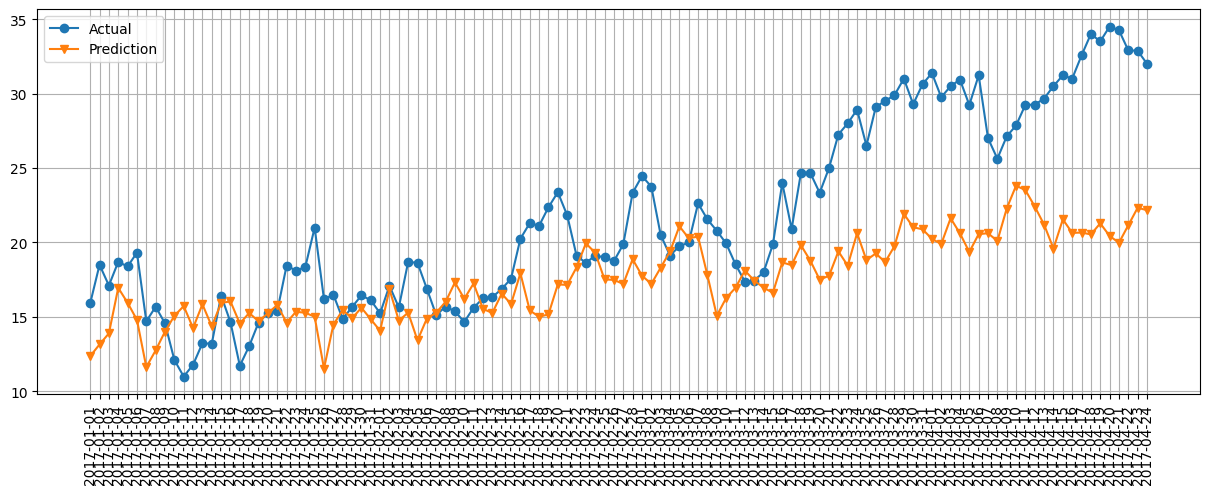

In [115]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(test['date'],test['meantemp'], marker='o', label='Actual')
plt.plot(test['date'],pred_arima, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [127]:
pred_arima['predicted_meantemp'].values

array([12.36776009, 13.15412274, 13.89760531, 16.95502007, 15.95222878,
       14.80386208, 11.63679617, 12.75445306, 14.01900967, 15.07644009,
       15.72787271, 14.25603024, 15.84980611, 14.36966342, 15.93755592,
       16.04677027, 14.55571561, 15.26707059, 14.70867928, 15.25071969,
       15.80353166, 14.62240012, 15.34491615, 15.28450187, 15.01223328,
       11.53643956, 14.47533384, 15.47037235, 14.90563341, 15.62116345,
       14.84415464, 14.07464618, 16.85254941, 14.7554039 , 15.29063649,
       13.42889877, 14.89470222, 15.28583761, 16.01398228, 17.32079355,
       16.21979286, 17.25041988, 15.53883963, 15.26892929, 16.56587357,
       15.86619688, 17.93524588, 15.44013897, 15.01201112, 15.17118328,
       17.18490131, 17.14984698, 18.32299106, 19.94591781, 19.30505842,
       17.52026827, 17.48970022, 17.21527626, 18.87652283, 17.77155927,
       17.2172697 , 18.31201954, 19.39571803, 21.08993609, 20.28589673,
       20.39618756, 17.79259937, 15.08225241, 16.27115421, 16.95

In [156]:
y_true = test_['meantemp'].values
y_pred = pred_arima.values
#print(pred_arima[:][1])

In [157]:
print("="*50)
print("="*50)
mape_=mean_absolute_percentage_error(y_true, y_pred)
print("Mean Absolute Percentage Error", mape_)
print("="*50)
mse_= mean_squared_error_(y_true, y_pred)
print("Mean Squared Error",mse_)
print("="*50)
print("RMSE", (mse_)**0.5)
print("Root Mean Squared Error", (mse_)**0.5)
print("="*50)
smape_ = smape(y_pred,y_true)
print("Symmetrical Mean Absolute Percentage Error (sMAPE)", smape_)
print("="*50)
mase_ = mase(y_pred,y_true)
print("Mean Absolute Scaled Error (MASE)" , mase_)
print("="*50)
rho_u_ = rho_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρU)", rho_u_)
print("="*50)
rho_o_ = rho_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρO)", rho_o_)
print("="*50)
delta_u_ = delta_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δU)", delta_u_)
print("="*50)
delta_o_ = delta_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δO)", delta_o_)
print("="*50)
r_squared_ = r_squared(y_pred,y_true)
print("Cofficient of Determination (R²)", r_squared_)
print("="*50)



Mean Absolute Percentage Error 0.19183837442262702
MSE: 64.77
Mean Squared Error 64.7674774403591
RMSE 8.047824391744586
Root Mean Squared Error 8.047824391744586
sMAPE: 3386.68%
Symmetrical Mean Absolute Percentage Error (sMAPE) 3386.6788762434735
MASE: 548.37
Mean Absolute Scaled Error (MASE) 548.3730770486998
ρU: 0.68
Mean Wrong-Estimation Shares (ρU) 0.6791320406278855
ρO: 0.32
Mean Wrong-Estimation Shares (ρO) 0.3208679593721145
ρU: 0.68
δU: 0.28
Mean Wrong-Estimation Shares (δU) 0.28161449962516344
ρO: 0.32
δO: 0.22
Mean Wrong-Estimation Shares (δO) 0.22192503960428905
R²: 0.09
Cofficient of Determination (R²) 0.09192641385432232


# SARIMAX Model 

In [158]:
train.head()

,date,meantemp,humidity,wind_speed
0,2013-01-01,10.000000,84.500000,0.000000
1,2013-01-02,7.400000,92.000000,2.980000
2,2013-01-03,7.166667,87.000000,4.633333
3,2013-01-04,8.666667,71.333333,1.233333
4,2013-01-05,6.000000,86.833333,3.700000


In [159]:
test.head()

,date,meantemp,humidity,wind_speed
0,2017-01-01,15.913043,85.869565,2.743478
1,2017-01-02,18.500000,77.222222,2.894444
2,2017-01-03,17.111111,81.888889,4.016667
3,2017-01-04,18.700000,70.050000,4.545000
4,2017-01-05,18.388889,74.944444,3.300000


In [160]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

def fit_sarimax(train, test, target_col, exog_cols, seasonal_period=12):
    # Prepare the data
    train_y = train[target_col]
    train_X = train[exog_cols]
    test_X = test[exog_cols]

    # Use auto_arima to determine the best parameters
    auto_model = auto_arima(train_y, exogenous=train_X, 
                            seasonal=True, m=seasonal_period,
                            start_p=0, start_q=0, max_p=5, max_q=5,
                            start_P=0, start_Q=0, max_P=2, max_Q=2,
                            d=None, D=None, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

    # Get the order and seasonal_order from auto_arima
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order

    # Fit the SARIMAX model
    model = SARIMAX(train_y, exog=train_X, order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # Make predictions
    predictions = results.forecast(steps=len(test), exog=test_X)

    return results, predictions

results, predictions = fit_sarimax(train, test, 'meantemp', ['humidity', 'wind_speed'])


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5650.181, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5615.079, Time=0.71 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5602.960, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5648.181, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5602.114, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5602.959, Time=0.88 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5604.958, Time=1.42 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5544.460, Time=0.48 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=5544.887, Time=1.59 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=5544.946, Time=2.38 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=5543.944, Time=5.32 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=5545.718, Time=14.52 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=5545.695, Time=15.84 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=5546.490, Time=6.94 sec
 ARIMA(1,1,1)(2,0

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64103D+00    |proj g|=  3.14302D-02


 This problem is unconstrained.



At iterate    5    f=  1.64043D+00    |proj g|=  2.70426D-03

At iterate   10    f=  1.64003D+00    |proj g|=  2.79226D-02

At iterate   15    f=  1.63543D+00    |proj g|=  7.49587D-02

At iterate   20    f=  1.62053D+00    |proj g|=  2.18927D-01

At iterate   25    f=  1.61690D+00    |proj g|=  1.58016D-03

At iterate   30    f=  1.61670D+00    |proj g|=  4.93323D-03

At iterate   35    f=  1.61659D+00    |proj g|=  2.50036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     60      1     0     0   4.565D-05   1.617D+00
  F =   1.6165869746201011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [161]:
print(predictions)

1462    12.324454
1463    13.748815
1464    13.423805
1465    15.328967
1466    14.733318
          ...    
1571    20.826936
1572    19.171617
1573    18.910016
1574    20.700159
1575    20.683005
Name: predicted_mean, Length: 114, dtype: float64


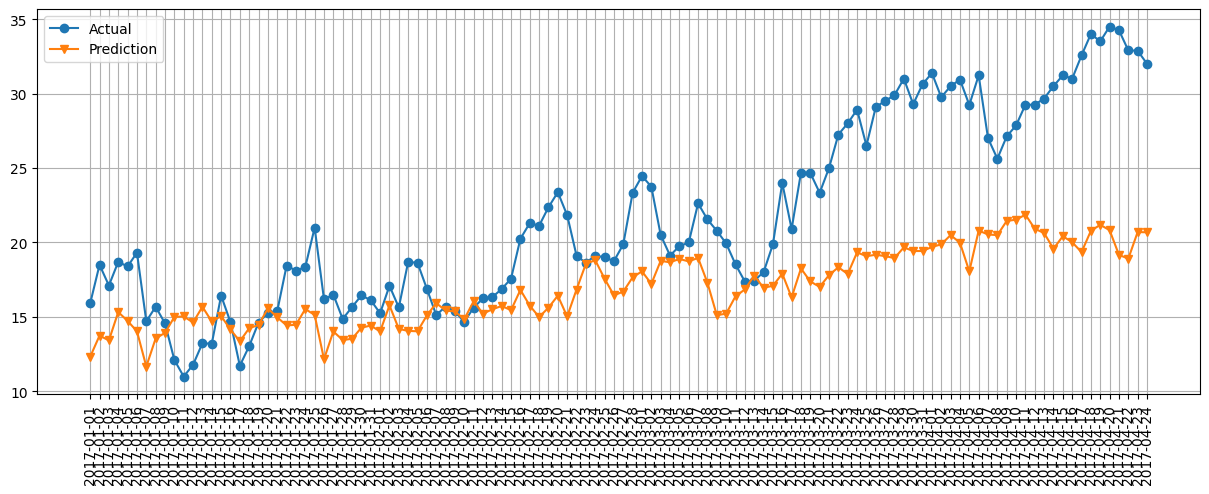

In [162]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(test['date'],test['meantemp'], marker='o', label='Actual')
plt.plot(test['date'],predictions, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [163]:
y_true = test['meantemp'].values
y_pred = predictions.values

In [164]:
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(y_true, y_pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error_(y_true, y_pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("Root Mean Squared Error", (mse)**0.5)
print("="*50)
smape_ = smape(y_pred,y_true)
print("Symmetrical Mean Absolute Percentage Error (sMAPE)", smape_)
print("="*50)
mase_ = mase(y_pred,y_true)
print("Mean Absolute Scaled Error (MASE)" , mase_)
print("="*50)
rho_u_ = rho_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρU)", rho_u_)
print("="*50)
rho_o_ = rho_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρO)", rho_o_)
print("="*50)
delta_u_ = delta_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δU)", delta_u_)
print("="*50)
delta_o_ = delta_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δO)", delta_o_)
print("="*50)
r_squared_ = r_squared(y_pred,y_true)
print("Cofficient of Determination (R²)", r_squared_)
print("="*50)



Mean Absolute Percentage Error 0.20755259853603256
MSE: 42.30
Mean Squared Error 42.295993054480626
RMSE 6.503536964950736
Root Mean Squared Error 6.503536964950736
sMAPE: 23.88%
Symmetrical Mean Absolute Percentage Error (sMAPE) 23.883250018332976
MASE: 3.95
Mean Absolute Scaled Error (MASE) 3.94596068114213
ρU: 0.89
Mean Wrong-Estimation Shares (ρU) 0.8947368421052632
ρO: 0.11
Mean Wrong-Estimation Shares (ρO) 0.10526315789473684
ρU: 0.89
δU: 0.22
Mean Wrong-Estimation Shares (δU) 0.21717833869541678
ρO: 0.11
δO: 0.13
Mean Wrong-Estimation Shares (δO) 0.12573380718126684
R²: -0.05
Cofficient of Determination (R²) -0.05487643397563846


# Other Linear Models 


# Linear Regressor

Coefficients: [-0.23298021  0.1733711 ]
Intercept: 38.474818144526665


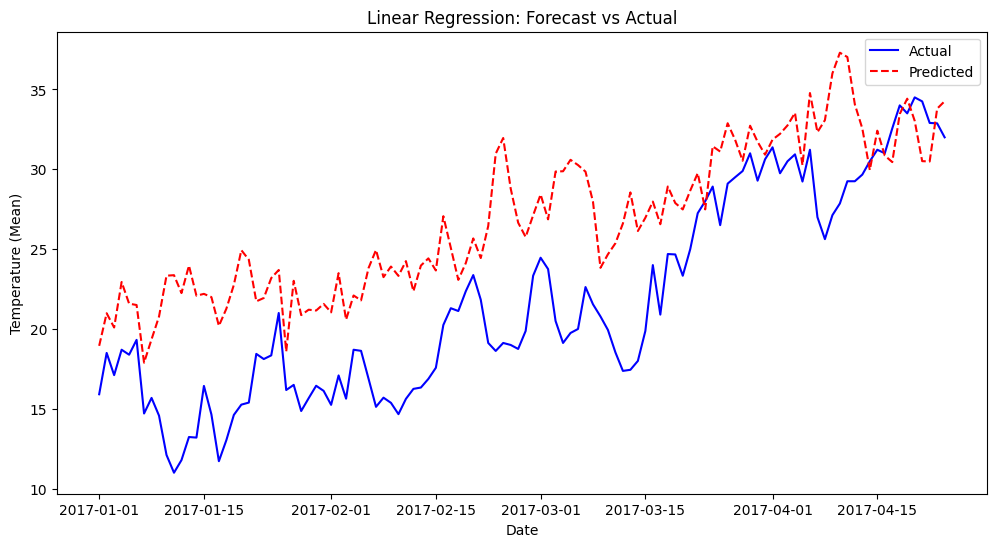

In [166]:



X_train = train.drop(columns=['date', 'meantemp'])
y_train = train['meantemp']
X_test = test.drop(columns=['date', 'meantemp'])
y_test = test['meantemp']


lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)


y_pred_LR = lin_reg.predict(X_test)



# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))


plt.plot(pd.to_datetime(test['date']), y_test, label='Actual', color='blue')


plt.plot(pd.to_datetime(test['date']), y_pred_LR, label='Predicted', color='red', linestyle='--')


plt.xlabel('Date')
plt.ylabel('Temperature (Mean)')
plt.title('Linear Regression: Forecast vs Actual')
plt.legend()
plt.show()


In [167]:
y_pred = y_pred_LR
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(y_true, y_pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error_(y_true, y_pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("Root Mean Squared Error", (mse)**0.5)
print("="*50)
smape_ = smape(y_pred,y_true)
print("Symmetrical Mean Absolute Percentage Error (sMAPE)", smape_)
print("="*50)
mase_ = mase(y_pred,y_true)
print("Mean Absolute Scaled Error (MASE)" , mase_)
print("="*50)
rho_u_ = rho_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρU)", rho_u_)
print("="*50)
rho_o_ = rho_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρO)", rho_o_)
print("="*50)
delta_u_ = delta_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δU)", delta_u_)
print("="*50)
delta_o_ = delta_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δO)", delta_o_)
print("="*50)
r_squared_ = r_squared(y_pred,y_true)
print("Cofficient of Determination (R²)", r_squared_)
print("="*50)



Mean Absolute Percentage Error 0.29316631212095007
MSE: 37.83
Mean Squared Error 37.825515412022206
RMSE 6.150245150562879
Root Mean Squared Error 6.150245150562879
sMAPE: 23.99%
Symmetrical Mean Absolute Percentage Error (sMAPE) 23.99250499293659
MASE: 4.07
Mean Absolute Scaled Error (MASE) 4.069010944357135
ρU: 0.07
Mean Wrong-Estimation Shares (ρU) 0.07017543859649122
ρO: 0.93
Mean Wrong-Estimation Shares (ρO) 0.9298245614035088
ρU: 0.07
δU: 0.04
Mean Wrong-Estimation Shares (δU) 0.04331938254710412
ρO: 0.93
δO: 0.31
Mean Wrong-Estimation Shares (δO) 0.31202268416425916
R²: 0.06
Cofficient of Determination (R²) 0.056618796969052476


# Ridge Regression with Polynomial Features

Best parameters for Ridge: {'alpha': 10}
Best cross-validation score for Ridge: 38.13243545528867
Best Ridge Regression
Coefficients: [-3.64201425  1.3968571  -0.42566116  0.67047967 -1.39551705]
Intercept: 25.495520655761762


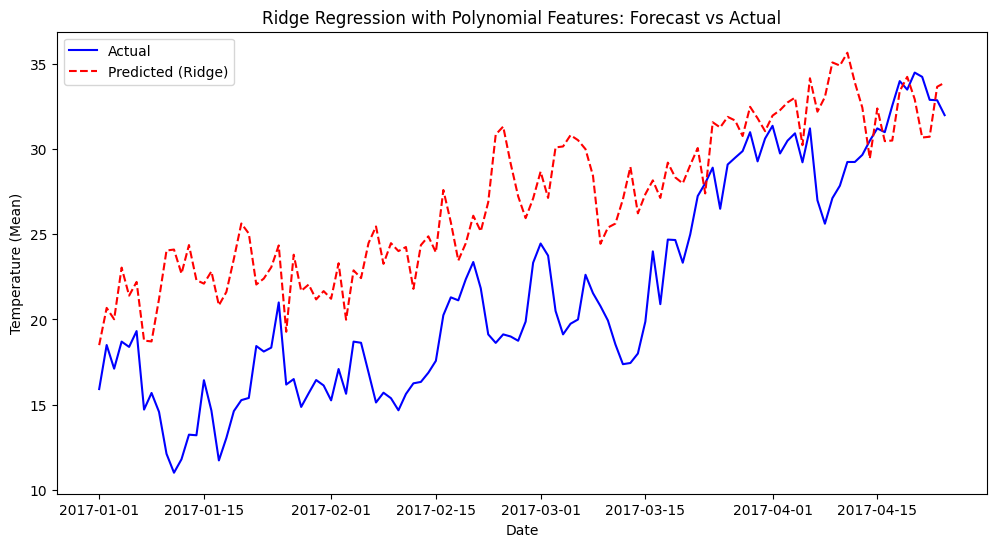

In [168]:

X_train = train.drop(columns=['date', 'meantemp'])
y_train = train['meantemp']
X_test = test.drop(columns=['date', 'meantemp'])
y_test = test['meantemp']


poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)


param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_search_ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_poly_scaled, y_train)

print("Best parameters for Ridge:", grid_search_ridge.best_params_)
print("Best cross-validation score for Ridge:", -grid_search_ridge.best_score_)

# Best model from Grid Search
best_ridge = grid_search_ridge.best_estimator_

# Predict on the test set with the best model
y_pred_best_ridge = best_ridge.predict(X_test_poly_scaled)

# Evaluate the model
print("Best Ridge Regression")
print("Coefficients:", best_ridge.coef_)
print("Intercept:", best_ridge.intercept_)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(pd.to_datetime(test['date']), y_test, label='Actual', color='blue')

# Plot the predicted values
plt.plot(pd.to_datetime(test['date']), y_pred_best_ridge, label='Predicted (Ridge)', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Temperature (Mean)')
plt.title('Ridge Regression with Polynomial Features: Forecast vs Actual')
plt.legend()
plt.show()



In [169]:
y_pred = y_pred_best_ridge
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(y_true, y_pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error_(y_true, y_pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("Root Mean Squared Error", (mse)**0.5)
print("="*50)
smape_ = smape(y_pred,y_true)
print("Symmetrical Mean Absolute Percentage Error (sMAPE)", smape_)
print("="*50)
mase_ = mase(y_pred,y_true)
print("Mean Absolute Scaled Error (MASE)" , mase_)
print("="*50)
rho_u_ = rho_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρU)", rho_u_)
print("="*50)
rho_o_ = rho_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρO)", rho_o_)
print("="*50)
delta_u_ = delta_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δU)", delta_u_)
print("="*50)
delta_o_ = delta_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δO)", delta_o_)
print("="*50)
r_squared_ = r_squared(y_pred,y_true)
print("Cofficient of Determination (R²)", r_squared_)
print("="*50)



Mean Absolute Percentage Error 0.3050767052802109
MSE: 40.22
Mean Squared Error 40.224767981762525
RMSE 6.3422998968641116
Root Mean Squared Error 6.3422998968641116
sMAPE: 24.77%
Symmetrical Mean Absolute Percentage Error (sMAPE) 24.773791582496468
MASE: 4.21
Mean Absolute Scaled Error (MASE) 4.208312909125496
ρU: 0.07
Mean Wrong-Estimation Shares (ρU) 0.07017543859649122
ρO: 0.93
Mean Wrong-Estimation Shares (ρO) 0.9298245614035088
ρU: 0.07
δU: 0.05
Mean Wrong-Estimation Shares (δU) 0.04599441070909923
ρO: 0.93
δO: 0.32
Mean Wrong-Estimation Shares (δO) 0.32463008600255894
R²: -0.00
Cofficient of Determination (R²) -0.00321937710371456


# LASSO Model

In [170]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

def create_features_numeric_only(df, target_col, exog_cols, lags=3):
    df = df.copy()
    
    # Ensure the index is datetime and sorted
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    # Create lag features for target variable
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    
    # Create lag features for exogenous variables
    for col in exog_cols:
        for lag in range(1, lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Drop rows with NaN values (due to lag creation)
    df = df.dropna()
    
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df[numeric_cols]
    
    return df

def train_lasso_numeric_only(train, test, target_col, exog_cols, lags=3):
    # Create features
    train_featured = create_features_numeric_only(train, target_col, exog_cols, lags)
    test_featured = create_features_numeric_only(test, target_col, exog_cols, lags)
    
    # Prepare the data
    feature_cols = [col for col in train_featured.columns if col != target_col]
    X_train = train_featured[feature_cols]
    y_train = train_featured[target_col]
    X_test = test_featured[feature_cols]
    y_test = test_featured[target_col]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Lasso model with cross-validation
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    
    # Make predictions
    train_predictions = lasso.predict(X_train_scaled)
    test_predictions = lasso.predict(X_test_scaled)
    

    
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': np.abs(lasso.coef_)
    }).sort_values('importance', ascending=False)
    
    return lasso, test_predictions, feature_importance

# Example usage:
lasso_model, lasso_predictions, feature_importance = train_lasso_numeric_only(train, test, 'meantemp', ['humidity', 'wind_speed'])

# Print results
print("Feature Importance:\n", feature_importance)
# print(f"Train MSE: {metrics[0]:.4f}, Test MSE: {metrics[1]:.4f}")
# print(f"Train R2: {metrics[2]:.4f}, Test R2: {metrics[3]:.4f}")

Feature Importance:
              feature  importance
2     meantemp_lag_1    6.618951
0           humidity    2.276344
5     humidity_lag_1    2.073739
4     meantemp_lag_3    0.513755
7     humidity_lag_3    0.223713
6     humidity_lag_2    0.222314
1         wind_speed    0.182187
10  wind_speed_lag_3    0.102180
9   wind_speed_lag_2    0.060335
8   wind_speed_lag_1    0.011460
3     meantemp_lag_2    0.000000


In [171]:
len(lasso_predictions)

111

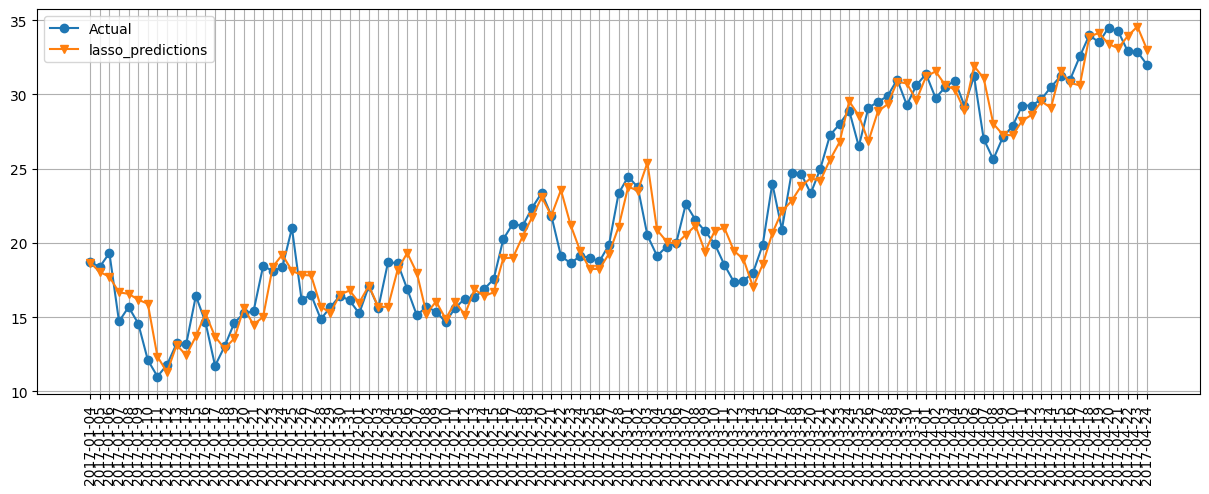

In [172]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(test['date'][3:],test['meantemp'][3:], marker='o', label='Actual')
plt.plot(test['date'][3:],lasso_predictions, marker='v', label='lasso_predictions')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [174]:
y_true = test['meantemp'][3:].values
y_pred = lasso_predictions


In [175]:

print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(y_true, y_pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error_(y_true, y_pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("Root Mean Squared Error", (mse)**0.5)
print("="*50)
smape_ = smape(y_pred,y_true)
print("Symmetrical Mean Absolute Percentage Error (sMAPE)", smape_)
print("="*50)
mase_ = mase(y_pred,y_true)
print("Mean Absolute Scaled Error (MASE)" , mase_)
print("="*50)
rho_u_ = rho_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρU)", rho_u_)
print("="*50)
rho_o_ = rho_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (ρO)", rho_o_)
print("="*50)
delta_u_ = delta_u(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δU)", delta_u_)
print("="*50)
delta_o_ = delta_o(y_pred,y_true)
print("Mean Wrong-Estimation Shares (δO)", delta_o_)
print("="*50)
r_squared_ = r_squared(y_pred,y_true)
print("Cofficient of Determination (R²)", r_squared_)
print("="*50)



Mean Absolute Percentage Error 0.05866789178233969
MSE: 2.38
Mean Squared Error 2.381577032004009
RMSE 1.5432358964215447
Root Mean Squared Error 1.5432358964215447
sMAPE: 5.78%
Symmetrical Mean Absolute Percentage Error (sMAPE) 5.775958123694441
MASE: 0.91
Mean Absolute Scaled Error (MASE) 0.9095327945347277
ρU: 0.54
Mean Wrong-Estimation Shares (ρU) 0.5405405405405406
ρO: 0.46
Mean Wrong-Estimation Shares (ρO) 0.4594594594594595
ρU: 0.54
δU: 0.05
Mean Wrong-Estimation Shares (δU) 0.0473788139298585
ρO: 0.46
δO: 0.07
Mean Wrong-Estimation Shares (δO) 0.07194915984408229
R²: 0.94
Cofficient of Determination (R²) 0.9413078518557454


# LINEAR MODELS COMPARISON

In [176]:
y_pred_arima = pred_arima
y_pred_sarimax = predictions

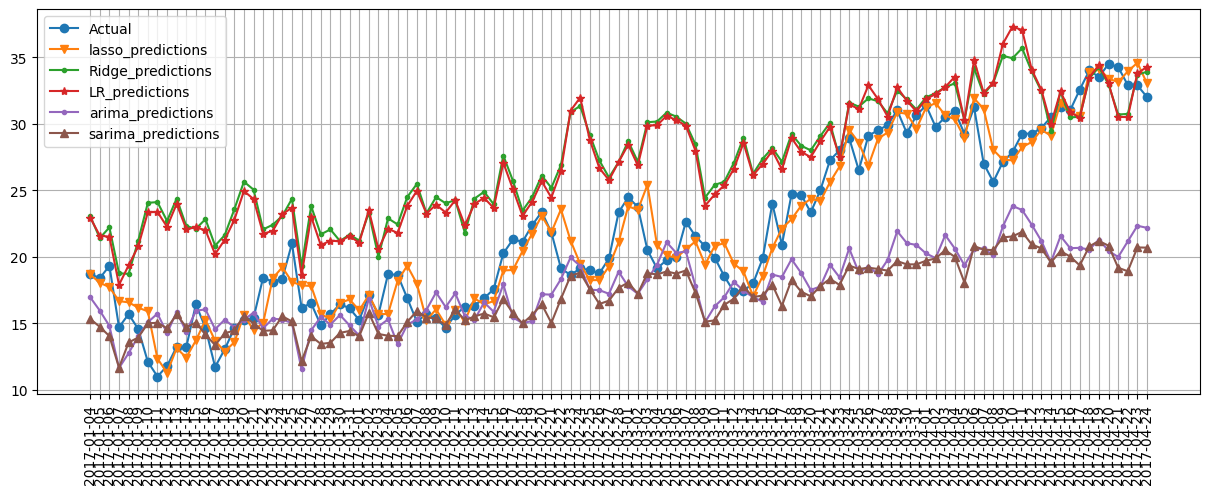

In [177]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(test['date'][3:],test['meantemp'][3:], marker='o', label='Actual')
plt.plot(test['date'][3:],lasso_predictions, marker='v', label='lasso_predictions')
plt.plot(test['date'][3:],y_pred_best_ridge[3:], marker='.', label='Ridge_predictions')
plt.plot(test['date'][3:],y_pred_LR[3:], marker='*', label='LR_predictions')
plt.plot(test['date'][3:],y_pred_arima[3:], marker='.', label='arima_predictions')
plt.plot(test['date'][3:],y_pred_sarimax[3:], marker='^', label='sarima_predictions')

plt.legend()
plt.xticks(rotation=90)
plt.show()



